# B.6 A Hidden-Markov Modeling Approach to Creating Synthetic Streamflow Scenarios

In this notebook, we will be covering the basics of fitting a Hidden Markov Model-based synthetic streamflow generator for a single site in the Upper Colorado River Basin. First, we will characterize the observed historical flow in the basin from 1909-2013. Then, we will fit a synthetic streamflow generator to the observed flows in the basin in order to create stationary synthetic flows. Finally, we will create a non-stationary version of the generator to create flows that could be representative of plausible future climate in the region. We ultimately show how to place the synthetically generated flows in the context of physically-informed CMIP5 projections to compare the two methods.  

## B6.1 Background

In the Western United States, and particularly the Colorado River Basin, a recent study used tree-ring reconstructions to suggest that the megadrought that has been occurring in the Southwest over the past 22 years is the regions worst drought since about 800 AD (Williams et al., 2022). The study's lead author, UCLA climatologist Park Williams, suggested that had the sequence of wet-dry years occurred without anthropogenic forcing, the 2000s would have likely still been dry, but not on the same level as the worst of the last millennium’s megadroughts.

The recent trend of warming and reduced soil moisture in the SW is becoming extremely problematic from a water systems planning and management perspective for the Colorado River Basin. It has becoming rapidly clear that the river is completely over-allocated and won't be able to sustain flow requirements as dictated by the Colorado Compact. Thus, there has been an increasing focus in understanding how susceptible water systems in this region are to plausible future streamflow scenarios. In this tutorial, we'll discuss how to create these scenarios using a Hidden Markov Model (HMM)- based synthetic generator. As discussed in [Section 2.1](https://uc-ebook.org/docs/html/2_diagnostic_modeling_overview_and_perspectives.html#overview-of-model-diagnostics) and [4.2](https://uc-ebook.org/docs/html/4_sensitivity_analysis_diagnostic_and_exploratory_modeling.html#consequential-dynamics-what-is-controlling-model-behaviors-of-interest) of the eBook, future climate conditions in the basin represent a deep uncertainty that can lead to highly consequential results. It is advantageous to create a model such as the HMM-based generator in order to facilitate the creation of many ensembles of streamflow that can ultimately be used to force regional water systems models to understand how characteristics of these ensembles affect regional water shortages, operations, and policies.    




<figure>
<center><img src="1-lede_pix_-_usbr-powell-8517152024_aa66437c2e_o-cropped.jpg" style="width:50%"></center>
<figcaption style="text-align:center"> Lake Powell shows persistent effects from drought (Source: U.S. Bureau of Reclamation) </figcaption>
</figure>


# Let's Get Started!

## B6.2 Observed Record

First let's take a look at the observed data from 1909-2013 for a specific site. In this example, we use the outlet gauge of the Upper Colorado River (USGS Gauge 09163500 at the Colorado-Utah state line). Below we create a plot of the annual streamflow.

In [ ]:
# install pinned version of hmmlearn
!pip install hmmlearn==0.2.7

In [1]:
# Import libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from random import random
from SALib.sample import latin
from scipy import stats as ss
import statistics 
import statsmodels.api as sm

# Import helper functions from local package 
from functions import fitmodel
from functions import plotstates
from functions import plotdist


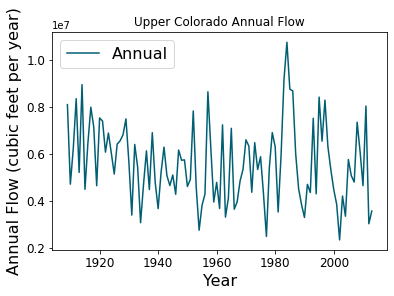

In [2]:
# Read in annual historical data
AnnualQ = pd.read_csv('uc_historical.csv')
AnnualQ['Year'] = list(range(1909, 2014))

# Plot a line graph
fig, ax = plt.subplots()
ax.plot(AnnualQ.iloc[:, 1],
        AnnualQ.iloc[:, 0],
        color='#005F73',
        label='Annual')

# Add labels and title
ax.set_title("Upper Colorado Annual Flow")
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Annual Flow (cubic feet per year)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rc('legend', fontsize=16)
legend = plt.legend() 


Let's calculate an 11-year rolling mean of the same data to get a sense of long-term trends. 

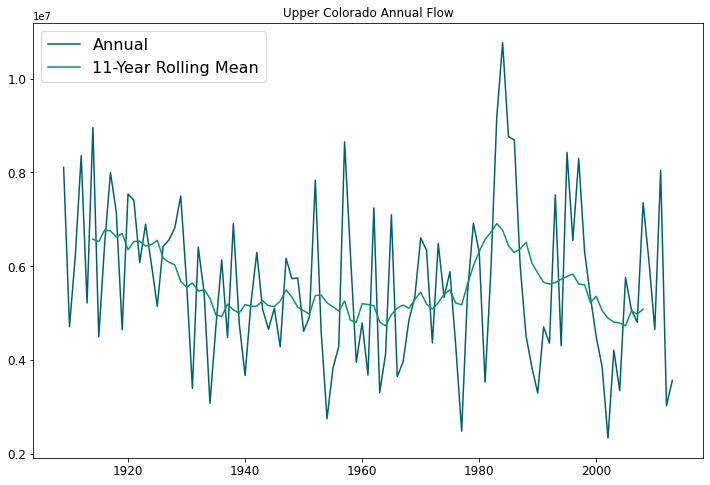

In [3]:
# Plot the original line graph
plt.plot(AnnualQ.iloc[:,1],
         AnnualQ.iloc[:,0],
         color='#005F73',
         label='Annual')

# Plot an 11-year rolling mean 
plt.plot(AnnualQ.iloc[:, 1].rolling(11).mean(),
         AnnualQ.iloc[:, 0].rolling(11).mean(),
         color='#0A9369',
         label='11-Year Rolling Mean')

# Add labels and title
plt.title("Upper Colorado Annual Flow")
ax.set_xlabel("Year",fontsize=16)
ax.set_ylabel("Annual Flow (cubic feet per year)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rc('legend', fontsize=16)
legend = plt.legend() 


The Colorado Compact, which presecribes flows between the Upper and Lower Colorado Basins, was negotiated using data prior to 1922, a time period revealed by the above figure to be one of the consistency wetter periods on record. It's clear today that since the 1980s, the Southwest has been experiencing imminent arridification and that this observed record alone isn't an accurate representation of what future climate might look like in this region.

Let's get a little more specific and formally quantify decadal droughts that have occured in the observed period. We use a metric proposed in Ault et al. (2014). The authors define a decadal drought as when the 11-year rolling mean falls below a threshold that is 1/2 a standard deviation below the overall mean of the record. We can then highlight the block of years that fall in a decadal drought using yellow rectangles below.

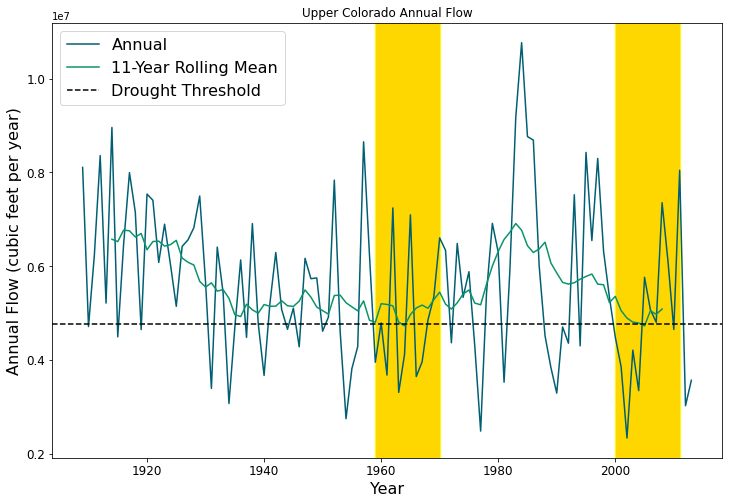

In [4]:
# Define drought threshold 
std = statistics.stdev(AnnualQ.iloc[:, 0])
threshold = np.mean(AnnualQ.iloc[:, 0] - (0.5 * std))

# Find where the rolling mean dip below the threshold?
drought_instances = [i for i, v in enumerate(AnnualQ.iloc[:,0].rolling(11).mean()) if v < threshold]
drought_years = AnnualQ.iloc[:, 1].rolling(11).mean()[drought_instances]

# Add labels and title
fig, ax = plt.subplots()
ax.plot(AnnualQ.iloc[:,1],
        AnnualQ.iloc[:,0],
        color='#005F73',
        label='Annual') 

ax.plot(AnnualQ.iloc[:,1].rolling(11,center=True).mean(),
        AnnualQ.iloc[:,0].rolling(11,center=True).mean(),
        color='#0A9369',
        label='11-Year Rolling Mean')

ax.axhline(y=threshold, 
           color='black', 
           linestyle='--',
           label='Drought Threshold')

# Visualize the drought periods as yellow rectangles
for i in drought_years:
    
    # Plot a box centered around those values and with 5 years on either side.
    rect = patches.Rectangle((i-5,0), 11,2e7, linewidth=1, edgecolor='yellow', facecolor='gold')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    
plt.title("Upper Colorado Annual Flow")
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Annual Flow (cubic feet per year)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rc('legend', fontsize=16)
legend = plt.legend() 


By this metric, the Upper Colorado Basin region has experienced two decadal droughts historically. 

## B6.3 Synthetic Stationary Generator to Better Quantify Natural Variability

It is important to remember that streamflow that we have observed in the region is only one instance of hydrology that can occur since the atmosphere is an inherently stochastic system. Thus, we require a tool that will allow us to see multiple plausible realizations of the same variability that characterizes the historical period. The tool that we use to develop synthetic flows for the region is a Gaussian Hidden Markov Model (HMM). If a system follows a Markov process, it switches between a number of "hidden states" dictated by a transition matrix. Each state has its own Gaussian probability distribution (defined by a mean and standard deviation) and one can draw from this distribution to create synthetic flows that fit the properties of the historical distribution. HMMs are an attractive choice for this region because they can simulate long persistence, particularly long droughts, which is characteristic of the region. The figure below shows an example of a 2-state Gaussian HMM that we will be fitting for this example.

<figure>
    <center><img src="HMM_example.png" style="width:75%"></center>
<figcaption style="text-align:center"> Two-state Gaussian HMM with mean and standard deviation parameters</figcaption>
</figure>


Below is the code that fits the HMM model to the last 2/3 of the historical record of log annual flows at the CO-UT stateline gauge and creates an alternative trace of 105 years. A subset of the dataset is chosen in order to minimize overfitting and to retain a set of data for validation of the model. When we fit our model, we utilize the Baum-Welch algorithm (a special version of the expectation-maximization algorithm) to find the optimal parameters that maximize the likelihood of seeing the observed flows. Ultimately the algorithm will return a mean and standard deviation associated with each state (mus and sigmas defined below) and a 2x2 transition probability matrix that captures the likelihood of transitioning between states (P). We can also retrieve the annual hidden states across the observed series, also known as the Viterbi sequence of states, which classifies each year in a "wet" or "dry" state. 

In [5]:
# Number of years for alternative trace
n_years = 105

# Import historical data that it used to fit HMM model 
AnnualQ_h = pd.read_csv('uc_historical.csv')

# Fit the model and pull out relevant parameters and samples 
logQ = np.log(AnnualQ_h)
hidden_states, mus, sigmas, P, logProb, samples, model = fitmodel.fitHMM(logQ, n_years)


We've fit our HMM, but what does the model look like? Let’s plot the annual time series of hidden states, or the Viterbi sequence. In the code, above, we have defined that the drier state is always represented by state 0. Thus, we know that hidden_states = 0 corresponds to the dry state and hidden_states = 1 to the wet state.

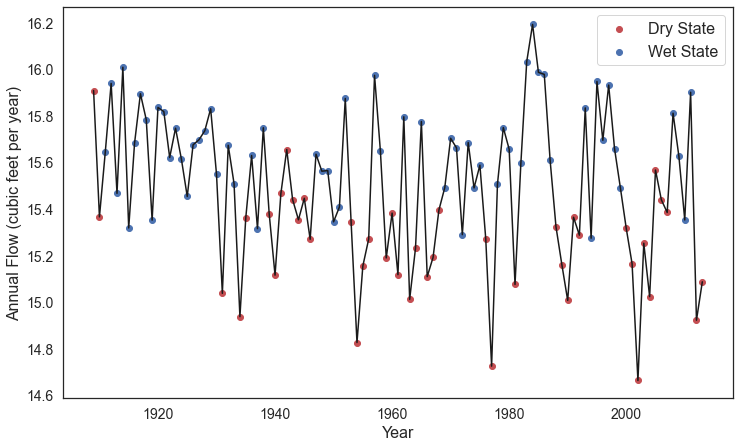

In [6]:
# Plot Vitebi sequence 
plotstates.plotTimeSeries(np.log(AnnualQ.iloc[:,0]), hidden_states, 'log(Flow at State Line)')


In the figure above, we see that the years with the higher log flows tend to be classified in a "wet" state and the opposite is true of the "dry" state. We can also print the transition matrix, which shows the likelihood of transitioning between states. Note that the system has a high likelihood of persisting in the same state.

In [7]:
print(model.transmat_)

[[0.65095026 0.34904974]
 [0.3205531  0.6794469 ]]


Let's also plot the distribution of the wet and dry state.

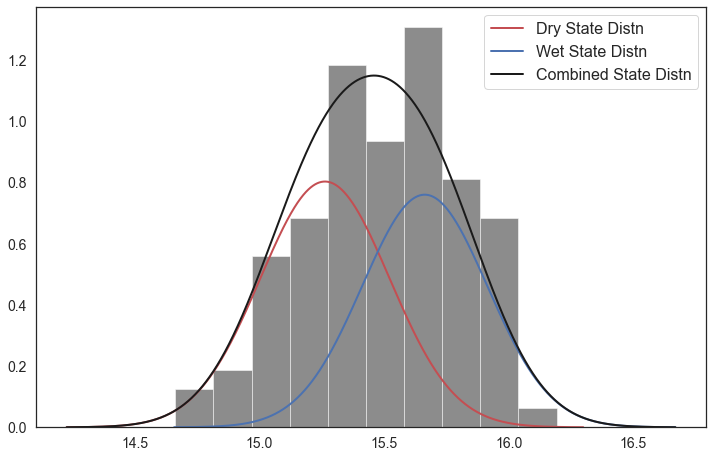

In [8]:
# Plot wet and dry state distributions
plotdist.plotDistribution(logQ, mus, sigmas, P)


The wet state distribution is characterized by a greater mean flow, but note that there is significant overlap in the tails of the distributions below which demonstrates why years with similiar flows can be classified in different states. 

Now let's see what the drought dynamics look like in the synthetic scenario that we created using the same definition that we had used for the historical period.

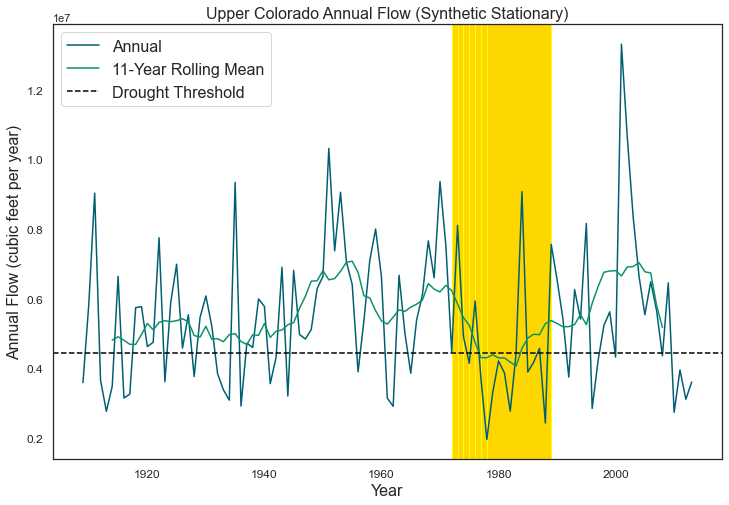

In [9]:
# Retrieve samples and back-transform out of log space
AnnualQ_s = np.exp(samples[0])
AnnualQ_s = pd.DataFrame(AnnualQ_s)
AnnualQ_s['Year'] = list(range(1909, 2014))

# Define drought threshold 
std=statistics.stdev(AnnualQ_s.iloc[:, 0])
threshold=np.mean(AnnualQ_s.iloc[:, 0] - (0.5 * std))

# Where does the rolling mean dip below the threshold
drought_instances = [i for i,v in enumerate(AnnualQ_s.iloc[:, 0].rolling(11).mean()) if v < threshold]
drought_years = AnnualQ_s.iloc[:, 1].rolling(11).mean()[drought_instances]

#Visualize the streamflow scenario
fig, ax = plt.subplots()

#Plot the original line graph
ax.plot(AnnualQ_s.iloc[:,1],
        AnnualQ_s.iloc[:,0],
        color='#005F73',
        label='Annual')

#Plot a 11-year rolling mean 
ax.plot(AnnualQ_s.iloc[:,1],
        AnnualQ_s.iloc[:,0].rolling(11, center=True).mean(),
        color='#0A9369',
        label='11-Year Rolling Mean')

# Add labels and title
ax.axhline(y=threshold, 
           color='black', 
           linestyle='--',
           label='Drought Threshold')


for i in drought_years:
    
    #Plot a box centered around those values and with 5 years on either side.
    rect = patches.Rectangle((i - 5,
                              0), 
                              11,
                              2e7, 
                              linewidth=1, 
                              edgecolor='yellow', 
                              facecolor='gold')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    
plt.title("Upper Colorado Annual Flow (Synthetic Stationary)",fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Annual Flow (cubic feet per year)", fontsize=16)
mpl.rc('legend', fontsize=16)
plt.legend() 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
mpl.rcParams['figure.figsize'] = [12, 8]


You can sample from the model and create more 105-year traces and note how the location and number of decadal droughts changes. This demonstrates how different the historical record can look just within the range of natural variability. It's also important to remember that when droughts occur can also define the ultimate effect of the drought (i.e. is it a time when there is a large population growth or a time when humans can adapt by conserving or building more infrastructure?). A hydrologic drought need not manifest into an agricultural or operational drought of the same magnitude if stored surface water is available. 

## B6.4 Non-Stationary Synthetic Generator to Impose Climate Changes

Now, we create flows under non-stationary conditions to get a better understanding of what flows can look like under climate changes. In order to create flows under non-stationary conditions, we can toggle the parameters of the HMM model in order to create systematic changes to the model that can represent a changing climate. The HMM has 6 parameters that define it. When we fit the historical model, the parameters that are fit represent a baseline parameter value. In this non-stationary generator, we define a range to sample these parameters from.

| Parameter | Current Value | Lower Bound | Upper Bound |
| :- | -: | :-: | :-: |
| Log-Space Wet State Mean Multiplier |1.00|0.98|1.02|
| Log-Space Dry State Mean Multiplier |1.00|0.98|1.02|
| Log-Space Wet State Standard Deviation Multiplier |1.00|0.75|1.25|
| Log-Space Dry State Standard Deviation Multiplier |1.00|0.75|1.25|
| Change in Dry-Dry Transition Probability |0.00|-0.30|+0.30|
| Change in Wet-Wet Transition Probability |0.00|-0.30|+0.30|


Now let's sample 1000 times from these bounds to create 1000 new parameterizations of the model. Here we use SALib and the Latin Hypercube sample function. 

In [10]:
# Create problem structure with parameters that we want to sample 
problem = {
    'num_vars': 6,
    'names': ['wet_mu', 'dry_mu', 'wet_std','dry_std','dry_tp',"wet_tp"],
    'bounds': [[0.98, 1.02],
               [0.98, 1.02],
               [0.75,1.25],
               [0.75,1.25],
               [-0.3,0.3],
               [-0.3,0.3]]
}

# generate 1000 parameterizations
n_samples = 1000

# set random seed for reproducibility
seed_value = 123

# Generate our samples 
LHsamples = latin.sample(problem, n_samples, seed_value)


Now let's look at what some of the traces look like in our non-stationary generator. Let's choose a random instance from the 1000-member space and adjust the parameters accordingly.

In [11]:
# Define static parameters 
n_years = 105

# Sample parameter; Adjust to any sample number from 0-999 
sample = 215 

# Create empty arrays to store the new Gaussian HMM parameters for each SOW
Pnew = np.empty([2,2])
piNew = np.empty([2])
musNew_HMM = np.empty([2])
sigmasNew_HMM = np.empty([2])
logAnnualQ_s = np.empty([n_years]) 

# Calculate new transition matrix and stationary distribution of SOW at last node as well as new means and standard deviations
Pnew[0, 0] = max(0.0, min(1.0, P[0, 0] + LHsamples[sample][4]))
Pnew[1, 1] = max(0.0, min(1.0, P[1, 1] + LHsamples[sample][5]))
Pnew[0, 1] = 1 - Pnew[0, 0]
Pnew[1, 0] = 1 - Pnew[1, 1]
eigenvals, eigenvecs = np.linalg.eig(np.transpose(Pnew))
one_eigval = np.argmin(np.abs(eigenvals - 1))
piNew = np.divide(np.dot(np.transpose(Pnew), eigenvecs[:, one_eigval]), 
                  np.sum(np.dot(np.transpose(Pnew), eigenvecs[:,one_eigval])))

musNew_HMM[0] = mus[0] * LHsamples[sample][1]
musNew_HMM[1] = mus[1] * LHsamples[sample][0]
sigmasNew_HMM[0] = sigmas[0] * LHsamples[sample][3]
sigmasNew_HMM[1] = sigmas[1] * LHsamples[sample][2]

# Generate first state and log-space annual flow at last node
states = np.empty([n_years])
if random() <= piNew[0]:
    states[0] = 0
    logAnnualQ_s[0] = ss.norm.rvs(musNew_HMM[0], sigmasNew_HMM[0])
else:
    states[0] = 1
    logAnnualQ_s[0] = ss.norm.rvs(musNew_HMM[1], sigmasNew_HMM[1])

# Generate remaining state trajectory and log space flows at last node
for j in range(1, n_years):
    if random() <= Pnew[int(states[j-1]), int(states[j-1])]:
        states[j] = states[j-1]
    else:
        states[j] = 1 - states[j-1]

    if states[j] == 0:
        logAnnualQ_s[j] = ss.norm.rvs(musNew_HMM[0], sigmasNew_HMM[0])
    else:
        logAnnualQ_s[j] = ss.norm.rvs(musNew_HMM[1], sigmasNew_HMM[1])

# Convert log-space flows to real-space flows
AnnualQ_s = np.exp(logAnnualQ_s)-1


Now let's see what this synthetic trace looks like.

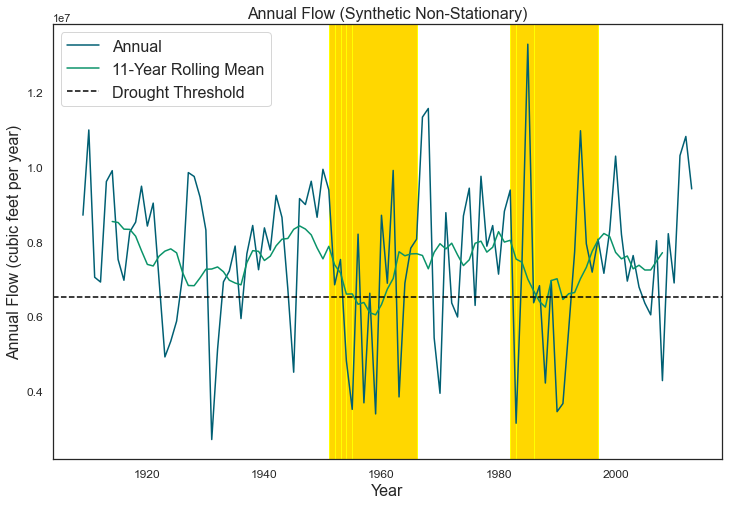

In [12]:
# Retrieve samples and back-transform out of log space
AnnualQ_s = pd.DataFrame(AnnualQ_s)
AnnualQ_s['Year'] = list(range(1909, 2014))

# Define drought threshold 
std = statistics.stdev(AnnualQ_s.iloc[:, 0])
threshold = np.mean(AnnualQ_s.iloc[:, 0] - (0.5 * std))

# Where does the rolling mean dip below the threshold
drought_instances = [i for i, v in enumerate(AnnualQ_s.iloc[:, 0].rolling(11).mean()) if v < threshold]
drought_years = AnnualQ_s.iloc[:, 1].rolling(11).mean()[drought_instances]

# Visualize the streamflow scenario
fig, ax = plt.subplots()

# Plot the original line graph
ax.plot(AnnualQ_s.iloc[:,1],
        AnnualQ_s.iloc[:,0],
        color='#005F73',
        label='Annual')

# Plot a 11-year rolling mean 
ax.plot(AnnualQ_s.iloc[:, 1],
        AnnualQ_s.iloc[:, 0].rolling(11, center=True).mean(),
        color='#0A9369',
        label='11-Year Rolling Mean')

# Add labels and title
ax.axhline(y=threshold, 
           color='black', 
           linestyle='--',
           label='Drought Threshold')


for i in drought_years:
    
    # Plot a box centered around those values and with 5 years on either side.
    rect = patches.Rectangle((i - 5,0), 
                             11,
                             2e7, 
                             linewidth=1, 
                             edgecolor='yellow', 
                             facecolor='gold')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    
plt.title("Annual Flow (Synthetic Non-Stationary)", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Annual Flow (cubic feet per year)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rc('legend', fontsize=16)
legend = plt.legend() 


Above is the example trace from the new non-stationary model. You may see fewer or more decadal drought instances. We can further summarize overall decadal drought characteristics across the samples. Let's plot a histogram of the total number of times we go below the drought threshold across these realizations. 

In [13]:
decadal_drought_occurence=np.empty([1000]) 

for y in range(1000):
    
    # Create empty arrays to store the new Gaussian HMM parameters for each SOW
    Pnew = np.empty([2, 2])
    piNew = np.empty([2])
    musNew_HMM = np.empty([2])
    sigmasNew_HMM = np.empty([2])
    logAnnualQ_s = np.empty([n_years]) 
    
    # Calculate new transition matrix and stationary distribution of SOW at last node
    # as well as new means and standard deviations

    Pnew[0, 0] = max(0.0,min(1.0, P[0, 0] + LHsamples[y][4]))
    Pnew[1, 1] = max(0.0,min(1.0, P[1, 1] + LHsamples[y][5]))
    Pnew[0, 1] = 1 - Pnew[0, 0]
    Pnew[1, 0] = 1 - Pnew[1, 1]
    eigenvals, eigenvecs = np.linalg.eig(np.transpose(Pnew))
    one_eigval = np.argmin(np.abs(eigenvals - 1))
    piNew = np.divide(np.dot(np.transpose(Pnew), eigenvecs[:, one_eigval]),
                      np.sum(np.dot(np.transpose(Pnew), eigenvecs[:, one_eigval])))

    musNew_HMM[0] = mus[0] * LHsamples[y][1]
    musNew_HMM[1] = mus[1] * LHsamples[y][0]
    sigmasNew_HMM[0] = sigmas[0] * LHsamples[y][3]
    sigmasNew_HMM[1] = sigmas[1] * LHsamples[y][2]

    # Generate first state and log-space annual flow at last node
    states = np.empty([n_years])
    if random() <= piNew[0]:
        states[0] = 0
        logAnnualQ_s[0] = ss.norm.rvs(musNew_HMM[0], sigmasNew_HMM[0])
    else:
        states[0] = 1
        logAnnualQ_s[0] = ss.norm.rvs(musNew_HMM[1], sigmasNew_HMM[1])

    # generate remaining state trajectory and log space flows at last node
    for j in range(1, n_years):
        if random() <= Pnew[int(states[j-1]), int(states[j-1])]:
            states[j] = states[j-1]
        else:
            states[j] = 1 - states[j-1]

        if states[j] == 0:
            logAnnualQ_s[j] = ss.norm.rvs(musNew_HMM[0], sigmasNew_HMM[0])
        else:
            logAnnualQ_s[j] = ss.norm.rvs(musNew_HMM[1], sigmasNew_HMM[1])

    # Convert log-space flows to real-space flows
    AnnualQ_s = np.exp(logAnnualQ_s) - 1
    AnnualQ_s = pd.DataFrame(AnnualQ_s)
    AnnualQ_s['Year'] = list(range(1909, 2014))

    # Define drought threshold 
    std = statistics.stdev(AnnualQ_s.iloc[:, 0])
    threshold = np.mean(AnnualQ_s.iloc[:, 0] - (0.5 * std))

    # Where does the rolling mean dip below the threshold
    drought_instances = [i for i, v in enumerate(AnnualQ_s.iloc[:, 0].rolling(11).mean()) if v < threshold]
    decadal_drought_occurence[y] = len(drought_instances)
    

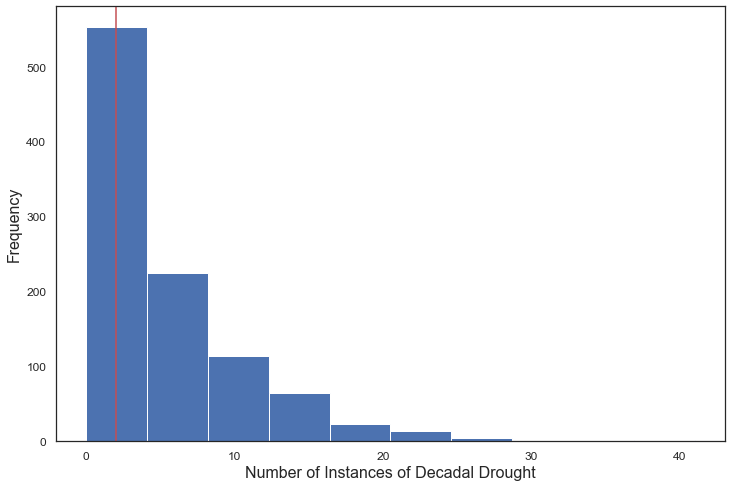

In [14]:
fig, ax = plt.subplots()
ax.hist(decadal_drought_occurence,label='Non-Stationary generator')
ax.set_xlabel('Number of Instances of Decadal Drought',fontsize=16)
ax.set_ylabel('Frequency',fontsize=16)
ax.axvline(x=2, color='r', linestyle='-',label='Observed')
mpl.rc('legend', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
mpl.rcParams['figure.figsize'] = [12, 8]


Note how many more instances of the decadal droughts we are creating with the non-stationary generator than our observed 105-year trace which creates a rich space in which we can test our models.

## B6.5 Placing CMIP5 Projections in the Context of Non-Stationary Flows 

We have broadened the drought conditions that we are creating which that can be very useful to understand how our water systems model performs under potentially extreme scenarios. However, it's useful to compare our bottom-up synthetically generated flows in the context of global physically-driven CIMP5 projections to get a better understanding of how the two approaches compare. We first aquire 97 CMIP5 projections from the Colorado River Water Availability Study (CWCB, 2012). In each of these projections, monthly precipitation factor changes and temperature delta changes were computed between mean projected 2035–2065 climate statistics and mean historical climate statistics from 1950–2013. These 97 different combinations of 12 monthly precipitation multipliers and 12 monthly temperature delta shifts were applied to historical precipitation and temperature time series from 1950–2013. The resulting climate time series were run through a Variable Infiltration Capacity (VIC) model of the UCRB, resulting in 97 time series of projected future streamflows at the Colorado‐Utah state line.

We fit an HMM to each trace of projected streamflow and get a set of corresponding HMM parameters. Then we take the ratio between these parameters and the baseline HMM parameters that we calculated earlier in the notebook in order to calculate the multipliers associated with each CMIP5 projection. This is all done externally, so we import the resulting multipliers in the next line.

In [15]:
# Read in CMIP5 and paleo multipliers
CMIP5_multipliers = pd.read_csv('CMIP5_SOWs.txt', header=None, sep=" ")


Let's plot a response surface that will allow us to see how combinations of HMM parameters tend to influence decadal drought. In order to get a continuous surface, we'll fit a non-linear regression to the parameter values and then predict the decadal drought over a set of grid points. We fit the response surface for two parameters that should have an affect on decadal drought: the dry distribution mean and the dry-dry transition probabilites. 

In [16]:
# Choose two parameters to fit the response surface for
mu_dry=[i[1] for i in LHsamples]
tp_dry=[i[4] for i in LHsamples]

# Create an interpolation grid
xgrid = np.arange(np.min(mu_dry),
                  np.max(mu_dry), 
                  (np.max(mu_dry) - np.min(mu_dry)) / 100)

ygrid = np.arange(np.min(tp_dry),
                  np.max(tp_dry), 
                  (np.max(tp_dry) - np.min(tp_dry)) / 100)

# Fit regression 
d = {'Dry_Tp': tp_dry, 
     'Dry_Mu': mu_dry,
     'Drought_Occurrence':decadal_drought_occurence}

df = pd.DataFrame(d)
df['Intercept'] = np.ones(np.shape(df)[0])
df['Interaction'] = df['Dry_Tp'] * df['Dry_Mu']
cols = ['Intercept'] + ['Dry_Mu'] + ['Dry_Tp'] + ['Interaction']
ols = sm.OLS(df['Drought_Occurrence'], df[cols])
result = ols.fit()

# Calculate drought occurence for each grid point
X, Y = np.meshgrid(xgrid, ygrid)
x = X.flatten()
y = Y.flatten()
grid = np.column_stack([np.ones(len(x)), x, y, x * y])
z = result.predict(grid)
z[z < 0.0] = 0.0 # replace negative shortage predictions with 0


Let's plot our results:

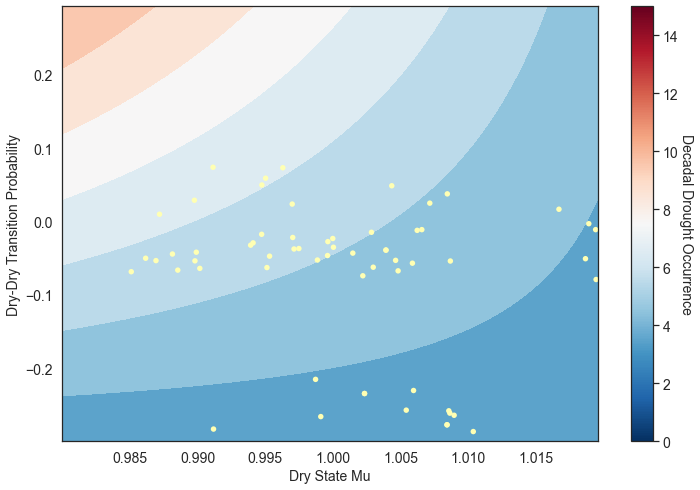

In [17]:
# Set color gradient for response surface 
drought_map = mpl.cm.get_cmap('RdBu_r')

# Reshape our predicted drought occurrence and define bounds of colors 
Z = np.reshape(z, np.shape(X))
vmin = np.min([np.min(z), np.min(df['Drought_Occurrence'].values)])
vmax = 15
norm = mpl.colors.Normalize(vmin, vmax)

# Plot response surface and CMIP5 projections
fig, ax = plt.subplots()
ax.contourf(X, Y, Z, cmap=drought_map, norm=norm)
ax.scatter(CMIP5_multipliers.iloc[:,7],
           CMIP5_multipliers.iloc[:,12], 
           c='#ffffb3', 
           edgecolor='none', 
           s=30)
cbar = ax.figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=drought_map), ax=ax)
ax.set_xlim(np.nanmin(X), np.nanmax(X))
ax.set_ylim(np.nanmin(Y), np.nanmax(Y))
ax.set_xlabel('Dry State Mu', fontsize=14)
ax.set_ylabel('Dry-Dry Transition Probability', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
cbar.ax.set_ylabel('Decadal Drought Occurrence', rotation=-90, fontsize=14, labelpad=15)
cbar.ax.tick_params(axis='y',labelsize=14)


We see the influence of the dry state mean and dry-dry transition parameters. We're likely to see more decadal droughts when we (1) increase the dry-dry transition probability, which inherently will increase persistence of the dry state, and (2) when we make the dry state log mean drier. Note that the CMIP5 scenarios tend to span the extent of the dry mean sample space, but are less representative of the dry transition probability sample space, which suggests that the types of hydrological droughts represented in the projections tend to only be wetter to slightly drier than our baseline. Both methods of producing these scenarios are valid, though studies have suggested that globally-resolved GCMs may be inappropriate to represent regional extremes. Ultimately, if your goal is to produce a variety of ensembles that are characterized by many different drought characteristics, you will likely find that a generator approach will serve this purpose better.

## B6.6 Tips to Create an HMM-Based Generator for your Problem

In this tutorial, we demonstrated how to fit an HMM-based generator for a single gauge located in the Upper Colorado River Basin. In order to apply this methodology to your problem, you will need to first ask: 

(1) Is this model appropriate for my location of interest? We have applied this style of generator to locations where persistent wet and dry states are characteristic, which tends to be in the Western US. Ultimately the best way to judge if an HMM is useful for your application is to fit the model and explore the resulting distributions. Are there two (or more) distinct states that emerge? If not, then your location may not exhibit the type of persistence that an HMM-based generator is useful for. You can consider exploring other styles of generators such as the Kirsch-Nowak generator (Kirsch et al., 2013).

(2) Do I have the right datasets? We use annual data for our location of interest. In this notebook, the HMM is fit to log annual flows. Ultimately, it can be disaggregated to daily flows (using a daily dataset) to be useful in water resources operational applications. You could also disaggregate to a finer resolution than daily if the historical dataset exists.   

If you meet these requirements, feel free to proceed through fitting the model using the code available in the notebook. 

## B6.7 References 

Ault, T. R., Cole, J. E., Overpeck, J. T., Pederson, G. T., & Meko, D. M. (2014). Assessing the risk of persistent drought using climate model simulations and paleoclimate data. Journal of Climate, 27(20), 7529-7549.

CWCB (2012).Colorado River Water Availability Study Phase I Report. Colorado Water Conservation Board

Williams, A. P., Cook, B. I., & Smerdon, J. E. (2022). Rapid intensification of the emerging southwestern North American megadrought in 2020–2021. Nature Climate Change, 12(3), 232-234.

Kirsch, B. R., Characklis, G. W., & Zeff, H. B. (2013). Evaluating the impact of alternative hydro-climate scenarios on transfer agreements: Practical improvement for generating synthetic streamflows. Journal of Water Resources Planning and Management, 139(4), 396-406.
